## First Attempt

This is slightly wrong but I still don't know why the objective function can be negative

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [ ]:
stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 48, 'station 5': 9}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# fill over, under stations
for station in stations:
    if start_levels[station] >= optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] <= optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # number of time steps
K = 2 # number of trucks
L = 3 # number of bikes that can be moved in one time step

In [3]:
model = gp.Model("bike_rebalancing")
# N = G.nodes()
# What is this for??

Academic license - for non-commercial use only - expires 2025-06-20
Using license file /Users/andrewyoo/gurobi.lic


In [4]:
'''
decision variables: 
x: whether or not truck k is at station s at time t
y: number of bikes available to truck k is at station s at time t
b: number of bikes in truck k at time t
'''
x, y, b = {}, {}, {}

for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s,t,k] = model.addVar(name="x_%s,%s,%s"%(s,t,k), vtype=GRB.BINARY)
            y[s,t,k] = model.addVar(name="y_%s,%s,%s"%(s,t,k), vtype=GRB.INTEGER)
        b[t,k] = model.addVar(name="b_%s,%s"%(t,k), vtype=GRB.INTEGER)

model.update()

In [5]:
# objective function

objective = gp.quicksum((optimal_levels[s] - y[s, T, 1]) for s in under_stations) \
            + gp.quicksum((y[s,T,1] - optimal_levels[s]) for s in over_stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

In [6]:
# constraints

# each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s,t,k] for s in stations) == 1)

# initiate
for s in stations:
    model.addConstr(sum(y[s,1,k] for k in range(1, K+1)) == start_levels[s])

# rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= optimal_levels[s])

# total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s,t,k] for s in stations) + b[t,k] == sum(y[s,1,k] for s in stations) + b[1,k])

# can move only when truck is at station, number of bikes moved is bounded by 
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s,t,k] - y[s,t-1,k] <= L * x[s,t,k])
            model.addConstr(y[s,t-1,k] - y[s,t,k] <= L * x[s,t,k])

# add last constraint later...

In [7]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 325 rows, 220 columns and 1066 nonzeros
Model fingerprint: 0x57ab964d
Variable types: 0 continuous, 220 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 72.0000000
Presolve removed 55 rows and 38 columns
Presolve time: 0.01s
Presolved: 270 rows, 182 columns, 770 nonzeros
Variable types: 0 continuous, 182 integer (88 binary)

Root relaxation: objective -1.200000e+01, 178 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -12.0000000  -12.00000  0.00%     -    0s

Explored 0 nodes (178 simplex iterations) in 0.04 sec

## Slight Fix

As you can see, I was getting negative values for the objective function, which is wrong. Introducing deviations seems to fix it...

In [36]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 30, 'station 5': 27}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 30 # Number of time steps
K = 3 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

travel_time = {
    ('station 1', 'station 2'): 1,
    ('station 1', 'station 3'): 1,
    ('station 1', 'station 4'): 3,
    ('station 1', 'station 5'): 1,
    ('station 2', 'station 3'): 1,
    ('station 2', 'station 4'): 3,
    ('station 2', 'station 5'): 1,
    ('station 3', 'station 4'): 3,
    ('station 3', 'station 5'): 1,
    ('station 4', 'station 5'): 3,
    # Symmetric entries
    ('station 2', 'station 1'): 1,
    ('station 3', 'station 1'): 1,
    ('station 4', 'station 1'): 3,
    ('station 5', 'station 1'): 1,
    ('station 3', 'station 2'): 1,
    ('station 4', 'station 2'): 3,
    ('station 5', 'station 2'): 1,
    ('station 4', 'station 3'): 3,
    ('station 5', 'station 3'): 1,
    ('station 5', 'station 4'): 3,
}

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b ,z= {}, {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)
        for s1 in stations:
            for s2 in stations:
                if s1 != s2:
                    z[s1, s2, t, k] = model.addVar(name="z_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if s1 != s2:
                    if t + travel_time[(s1, s2)] <= T:
                        model.addConstr(z[s1, s2, t, k] <= x[s1, t, k])
                        model.addConstr(z[s1, s2, t, k] <= x[s2, t + travel_time[(s1, s2)], k])
                        model.addConstr(z[s1, s2, t, k] >= x[s1, t, k] + x[s2, t + travel_time[(s1, s2)], k] - 1)
                        


model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7401 rows, 2795 columns and 20473 nonzeros
Model fingerprint: 0x2ab721be
Variable types: 0 continuous, 2795 integer (2250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 583 rows and 108 columns
Presolve time: 0.03s
Presolved: 6818 rows, 2687 columns, 18374 nonzeros
Variable types: 0 continuous, 2687 integer (2142 binary)
Found heuristic solution: objective 54.0000000
Found heuristic solution: objective 51.0000000

Root relaxation: objective 0.000000e+00, 1734 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   35   51.00000    0.00000   100%     -

## Graphing

Something is still not working right because it seems like trucks are reducing the number of bikes in station 4 just by making trips back to station 4 again and again which doesn't make sense... intuitively, they would have to go to a different station first to drop off the bikes...

Truck 1 path: [(1, 'station 1', '0 bikes'), (2, 'station 1', '0 bikes'), (3, 'station 4', '0 bikes'), (4, 'station 4', '3 bikes'), (5, 'station 4', '1 bikes'), (6, 'station 5', '0 bikes'), (7, 'station 4', '0 bikes'), (8, 'station 4', '0 bikes'), (9, 'station 1', '0 bikes'), (10, 'station 4', '0 bikes'), (11, 'station 4', '0 bikes'), (12, 'station 4', '0 bikes'), (13, 'station 4', '3 bikes'), (14, 'station 1', '3 bikes'), (15, 'station 5', '0 bikes'), (16, 'station 4', '0 bikes'), (17, 'station 5', '0 bikes'), (18, 'station 5', '0 bikes'), (19, 'station 5', '3 bikes'), (20, 'station 2', '3 bikes'), (21, 'station 2', '0 bikes'), (22, 'station 2', '0 bikes'), (23, 'station 1', '0 bikes'), (24, 'station 4', '0 bikes'), (25, 'station 4', '3 bikes'), (26, 'station 5', '3 bikes'), (27, 'station 2', '3 bikes'), (28, 'station 2', '0 bikes'), (29, 'station 4', '0 bikes'), (30, 'station 4', '3 bikes')]
Truck 2 path: [(1, 'station 4', '0 bikes'), (2, 'station 4', '0 bikes'), (3, 'station 3', '0 b

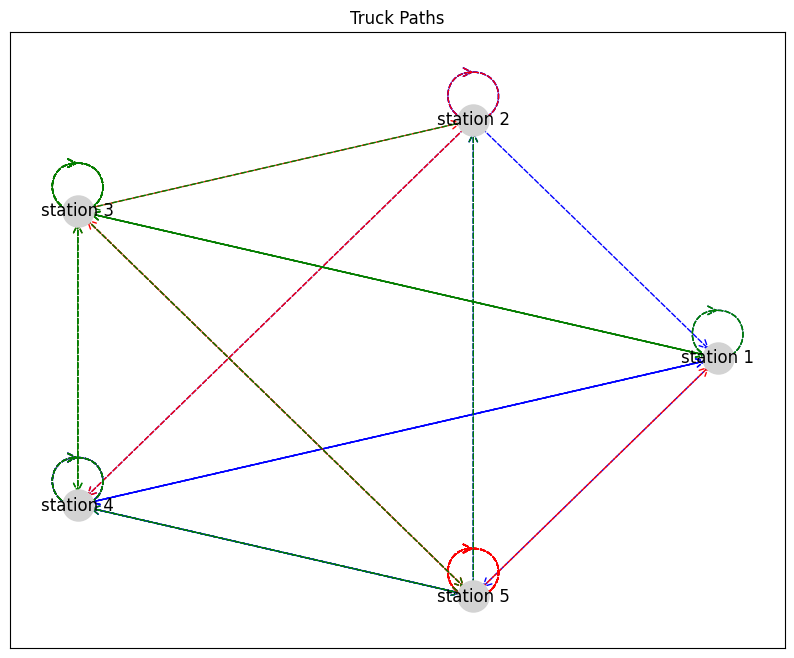

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}
if model.status == GRB.OPTIMAL:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")


# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.1  # You can adjust the radius as needed

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i][:2]
            t2, s2 = path[i + 1][:2]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    #plt.legend()
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)


In [43]:
print('Time 0:', start_levels)
for t in range(1, T+1):
    dict = {}
    for s in stations:
        dict[s] = int(sum(y[s,t,k].x for k in range(1,K+1)))
    print('Time {}:'.format(t), dict)

Time 0: {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 30, 'station 5': 27}
Time 1: {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 30, 'station 5': 27}
Time 2: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 30, 'station 5': 27}
Time 3: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 30, 'station 5': 27}
Time 4: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 24, 'station 5': 27}
Time 5: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 26, 'station 5': 27}
Time 6: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 26, 'station 5': 25}
Time 7: {'station 1': 21, 'station 2': 3, 'station 3': 3, 'station 4': 26, 'station 5': 25}
Time 8: {'station 1': 21, 'station 2': 3, 'station 3': 6, 'station 4': 26, 'station 5': 25}
Time 9: {'station 1': 21, 'station 2': 3, 'station 3': 6, 'station 4': 26, 'station 5': 25}
Time 10: {'station 1': 18, 'station 2': 3, 'station 3': 7, 'station 4': 26, 'sta

# Animation: Keeps Previous Time Steps

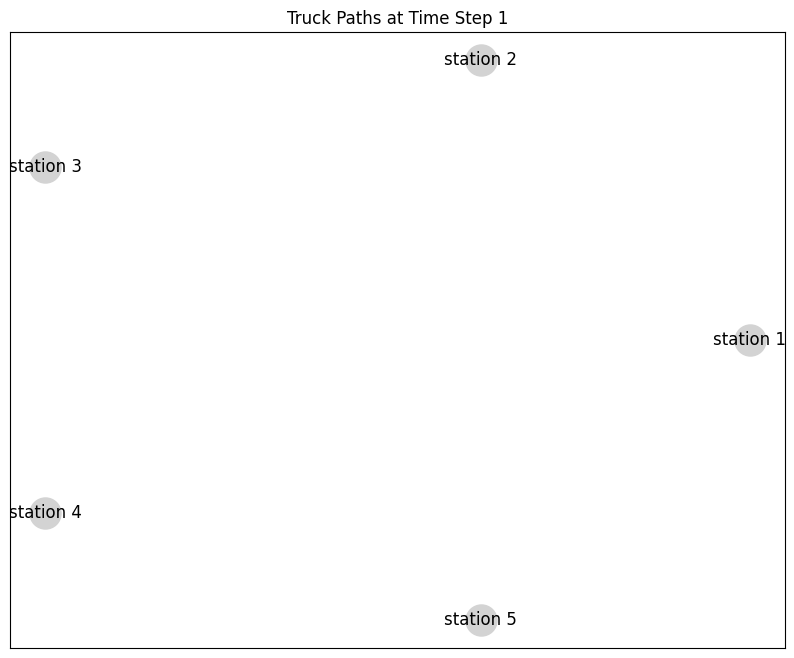

In [39]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.3  # Radius for station placement

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path up to the current frame
    # for k, path in truck_paths.items():
    #     current_path = [p for p in path if p[0] <= frame]
    #     if len(current_path) > 1:
    #         edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
    #         nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
    #                                edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    for k, path in truck_paths.items():
        current_path = [p for p in path if p[0] == frame]
        if len(current_path) > 1:
            edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                       edge_color=colors[k-1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame + 1}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=T, interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

# ani.save('truck_paths_animation.html', writer='html')

# Only Current Time Steps

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7fb8a0eebdc0> (for post_execute), with arguments args (),kwargs {}:


IndexError: list index out of range

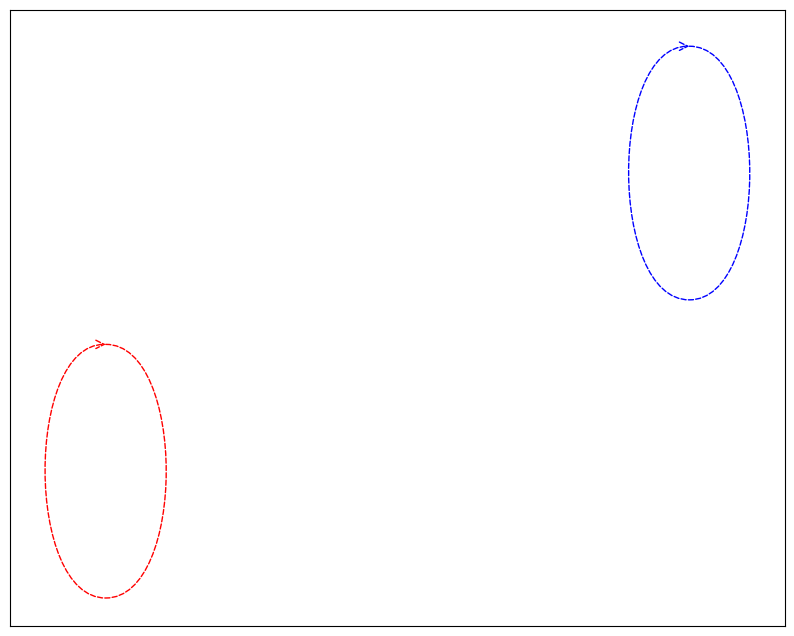

In [41]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())


In [ ]:
# Without Graphing Stationary Trips

In [ ]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation


# Calculate positions of the stations once
num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red', 'green']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame and path[i][1] != path[i + 1][1]]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

ani.save('truck_paths_animation.html', writer = 'html')
